In [22]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from keras import Model, Input
from keras.layers import Layer

import numpy as np
from datetime import datetime, timedelta
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from glob import glob
import os
import sys
import copy

In [23]:
# special class made for allowing the models (developed in keras 2) to be loaded in keras 3
class TFSMLayer(Layer):
    def __init__(self, filepath, call_endpoint="serving_default", **kwargs):
        super().__init__(**kwargs)
        self.filepath = filepath
        self.call_endpoint = call_endpoint
        self._infer = None  # will be loaded in build()

    def build(self, input_shape):
        # Load SavedModel once; save the TF function to self._infer
        self._loaded_model = tf.saved_model.load(self.filepath)
        self._infer = self._loaded_model.signatures[self.call_endpoint]
        super().build(input_shape)

    def call(self, inputs):
        # Ensure inputs are a tensor, pass through TF function, return the tensor output
        outputs = self._infer(inputs)
        
        # Pick the actual tensor output key here (adjust if needed)
        #return outputs['max_pooling2d_4']
        return list(outputs.values())[0] 

    def compute_output_shape(self, input_shape):
        # Return the expected output shape, for example (None, 26, 26, 1)
        # You may need to adapt this based on your actual model output
        batch_size = input_shape[0]
        return (batch_size, 26, 26, 1)

    def get_config(self):
        config = super().get_config()
        config.update({
            'filepath': self.filepath,
            'call_endpoint': self.call_endpoint,
        })
        return config

In [24]:
def load_input_data(initialisation_time):
    
    dt_time = datetime.strptime(initialisation_time, '%Y%m%d%H%M')
    time_1 = dt_time - timedelta(hours=lead_time + 1)
    time_0 = dt_time - timedelta(hours=lead_time)
    
    hours = ["{:02}".format(time.hour) for time in [time_1, time_0]]
    days = ["{:02}".format(time.day) for time in [time_1, time_0]]
    months = ["{:02}".format(time.month) for time in [time_1, time_0]]
    years = ["{:02}".format(time.year) for time in [time_1, time_0]]
    
    # This looks for himawari BT .nc files under the filepath structure YYYY/mm/dd/himawari_10.4_YYYYmmdd_HHMM.nc
    # change to match your own directory
    dates = [years[i] + months[i] + days[i] for i in range(len(days))]
    path_list = [path + years[i] + '/' + months[i] + '/' + days[i] +'/himawari_10.4_' + dates[i] + '_' + hours[i] + '00.nc' for i in range(len(days))]
    
    # load data using xarray - the (0,1) time dimensions represent the input BT fields, the (2) time dimension represents the BT field at the valid time
    data_xr = xr.open_mfdataset(path_list, combine='nested', concat_dim=['time']).sel(lon=slice(94.02, 141.7), lat=slice(-14.99,9))
    
    return data_xr

In [5]:
def entire_indo_nowcast(data_xr, model):
    
    # Split up the BT input into tiles with correct dimensions for SII-NowNet and individually input them (logging each tile prediction)
    # Each tile must overlap the neighbouring tiles by 16 pixels (1 grid box in SII-NowNet's nowcasts)
    
    tile_pred_list = []
    for i in range(4):
        for j in range(2):

            # only used the (1,2) time dimensions as input
            tile = data_xr['T_b'][:2,j*(416-16):j*(416-16)+416, i*(416-16):i*(416-16)+416]
            tile_data = tile.values.transpose(1,2,0)[np.newaxis]
            tile_data = normalize(tile_data, max_val, min_val)
            
            tile_pred = model.predict(tile_data, verbose=False)
            tile_pred_list.append(tile_pred[0,:,:,0])
    
    # Replace the overlap points (one SII-NowNet grid overlap) by the mean of the overlaps at each grid 
    tile_pred_array = np.array(tile_pred_list)
    mean_tile_pred_array = tile_pred_array.copy()  
    overlap_differences = []
    
    # define overlap index pairs (vertical: +2, horizontal: +1 on odd indices)
    vertical_pairs = [(0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7)]
    horizontal_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]
    
    # mean vertical overlaps
    for a, b in vertical_pairs:
        mean_vals = (tile_pred_array[a, :26, -1] + tile_pred_array[b, :26, 0]) / 2
        mean_tile_pred_array[a, :26, -1] = mean_tile_pred_array[b, :26, 0] = mean_vals
    
    # mean horizontal overlaps
    for a, b in horizontal_pairs:
        mean_vals = (tile_pred_array[a, -1, :26] + tile_pred_array[b, 0, :26]) / 2
        mean_tile_pred_array[a, -1, :26] = mean_tile_pred_array[b, 0, :26] = mean_vals

    # stitch together onto one domain
    grid_dim = 26
    overlap = 1
    nowcast_domain = np.zeros((grid_dim*2-overlap, grid_dim*4-3*overlap))
    
    for i in range(4):
        for j in range(2):
            nowcast_domain[j*(grid_dim-overlap):j*(grid_dim-overlap)+grid_dim, i*(grid_dim-overlap):i*(grid_dim-overlap)+grid_dim] = mean_tile_pred_array[2*i+j]

    return nowcast_domain

In [6]:
# This cell normalises the BT data (between 0 and 1) before it is inputted to SII-NowNet
# max_val and min_val are pre-defined and were obtained during SII-NowNet development. They must not be changed.

max_val = 327.67
min_val = 177.81

def normalize(array, max_val, min_val):
    
    array = (array - min_val) / (max_val - min_val + 1e-13)
    
    return array

In [32]:
initialisation_time = '202003050900' # must be in YYYYmmddHHMM time format, representing the nowcast initialisation time
lead_time = 1 # initiation: 1 or 2 hours, intensification: 1 or 2 or 3 hours
nowcast_type = 'intensification' # 'initiation' or 'intensification' 
model_file_path = './SII-NowNet_2_models/' 

In [27]:
# path to the Himawari BT data (in NetCDF format) - change to match your own directory
path = '/gws/nopw/j04/terramaris/peatman/himawari/nc_SEA/13/'

In [28]:
# load the BT input data
input_data = load_input_data(initialisation_time)

In [29]:
# Build the SII-NowNet model that matches your chosen lead time and nowcast_type
inputs = Input(shape=(416, 416, 2))
outputs = TFSMLayer(filepath=model_file_path + str(lead_time) + '_' + nowcast_type, call_endpoint='serving_default', trainable=False)(inputs)
model = Model(inputs, outputs)

In [30]:
# generate the nowcast for the whole Indonesian domain
nowcast = entire_indo_nowcast(input_data, model)

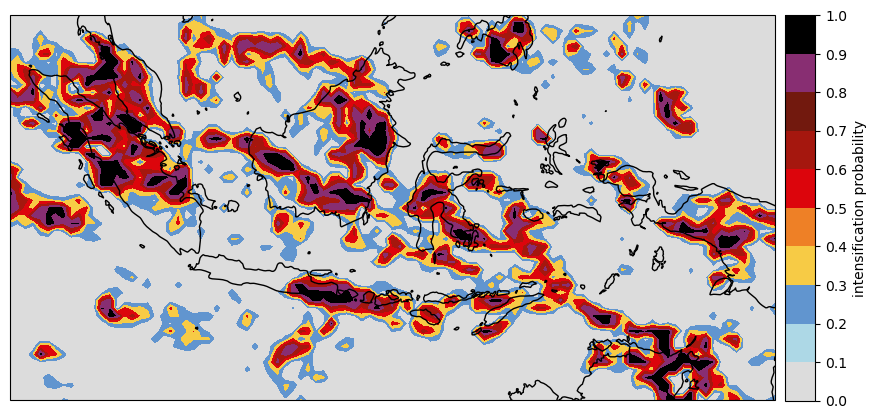

In [31]:
fig = plt.figure(figsize=(17,5))

min_lon=94.02 
max_lon=141.7
min_lat=-15
max_lat=9

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()

# plot intensification nowcast
if nowcast_type == 'intensification':
    
    tol_precip_colors = ["gainsboro", "lightblue", "#6195CF","#F7CB45","#EE8026","#DC050C","#A5170E","#72190E","#882E72","#000000"]
    precip_colormap = mpl.colors.ListedColormap(tol_precip_colors[:])
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    plt.colorbar(mpl.cm.ScalarMappable(cmap=precip_colormap,norm=norm), label=nowcast_type+' probability',extend='neither',ticks=np.arange(0,1.1,0.1), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0.1, axes_class=maxes.Axes))
    
    ax.contourf(nowcast,transform=ccrs.PlateCarree(), vmin=0, vmax=1, extent=[min_lon, max_lon, min_lat, max_lat], cmap=precip_colormap)
    
# plot initiation nowcast
if nowcast_type == 'initiation':
    tol_precip_colors = ["gainsboro","gainsboro","lightblue", "#6195CF","#F7CB45","#EE8026","#DC050C","#A5170E","#72190E","#882E72","#000000"]
    precip_colormap = mpl.colors.ListedColormap(tol_precip_colors[:])
    bounds = [0,0.01,0.02,0.03,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
    norm = mpl.colors.BoundaryNorm(bounds,12, extend='both')
    divider = make_axes_locatable(ax)
    plt.colorbar(mpl.cm.ScalarMappable(cmap=precip_colormap,norm=norm), label=nowcast_type+' probability',extend='neither',ticks=bounds, cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0.1, axes_class=maxes.Axes))
    
    ax.contourf(nowcast, transform=ccrs.PlateCarree(), extent=[min_lon, max_lon, min_lat, max_lat], cmap=precip_colormap)
    